In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

vegetable-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
import zipfile

local_zip = '/content/vegetable-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/data/Vegetable Images/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/data/Vegetable Images/validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

# Define a callback for printing the learning rate at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [ ]:
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,mode="min",restore_best_weights=True,),
    PrintLR()
]

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

In [ ]:
class_map = train_generator.class_indices

In [ ]:
IMAGE_SIZE = [224, 224]

VGG = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in VGG.layers:
    layer.trainable = False

x = VGG.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=VGG.input, outputs=prediction)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(train_generator, epochs=10, steps_per_epoch=400,
                    validation_data = validation_generator,
                    verbose = 1, validation_steps=80)

Epoch 1/10
284/400 [====================>.........] - ETA: 59s - loss: 1.7455 - accuracy: 0.5003

In [ ]:
model.save('/content/modhel.h5')

In [ ]:
filename = os.path.join('/content', 'model.h5')
model = tf.keras.models.load_model(filename)

In [ ]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def pred(fn):
  path =  fn
  img = image.load_img(path, target_size=(224, 224,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  x /= 255.
  classes = model.predict(x, batch_size=32)
  index=np.argmax(classes[0])
  img = mpimg.imread(fn)
  imgplot = plt.imshow(img)
  plt.title("Prediction - {}".format(category[index]))
  plt.show()

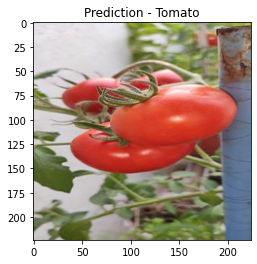

In [ ]:
pred('/content/data/Vegetable Images/test/Tomato/1011.jpg')
